# Google Analytics Customer Revenue Prediction by XGboost

We are under a digital world and the popularity of mobile device faster the transformation process, as a result, our digital footprints have been recorded. All these information help company, especially e-commence to understand more on customer behaviour, no matter implicit(click, duration of view) or explicit(rating, comment, purchase). Thus, marketing teams can formulate customized and targetted marketing.

Objective: analyze Google Merchandise Store (GStore) customer dataset to predict revenue per customer so that marketing teams can make appropriate investments in promotional strategies.

Dataset is provided from kaggle
Source: https://www.kaggle.com/c/ga-customer-revenue-prediction

# Data wrangling

Thank to julian3833, below codes help loading the data and flattening the json fields.

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

def load_df(csv_path='train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [2]:
train = load_df()

<ipython-input-1-03e75a01acca>:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  column_as_df = json_normalize(df[column])


Loaded train_v2.csv. Shape: (1708337, 60)


In [331]:
test = load_df(csv_path='test_v2.csv')

TypeError: load_df() got an unexpected keyword argument 'dtype'

In [13]:
train['totals.transactionRevenue'] = pd.to_numeric(train['totals.transactionRevenue'], errors='ignore')

In [89]:
train.head(1).T

,0
channelGrouping,Organic Search
customDimensions,"[{'index': '4', 'value': 'EMEA'}]"
date,20171016
fullVisitorId,3162355547410993243
hits,"[{'hitNumber': '1', 'time': '0', 'hour': '17',..."
visitId,1508198450
visitNumber,1
visitStartTime,1508198450
device.browser,Firefox
device.operatingSystem,Windows


# EDA

In [13]:
pip install seaborn

     |████████████████████████████████| 285 kB 9.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [94]:
import seaborn as sns

In [118]:
import matplotlib.pyplot as plt

First, let's find out the proportion of having online purchase in Google Merchandise Store (GStore). The below figure shows that most visiters of Gstore are just "window-shopping", and the exact conversion rate is just 1.08%.

<AxesSubplot:xlabel='totals.transactionRevenue', ylabel='Count'>

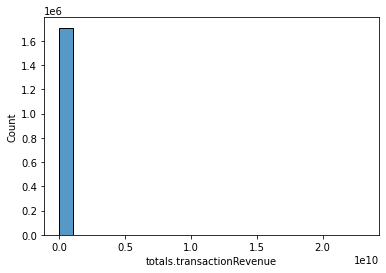

In [79]:
sns.histplot(data=train['totals.transactionRevenue'])

In [78]:
conversion = train['totals.transactionRevenue'].loc[train['totals.transactionRevenue']>0].count()/train['fullVisitorId'].count()
print("Conversion rate is {}%".format(round(conversion*100,2)))

Conversion rate is 1.08%


As shown below, there are many columns in the dataset. Some features may only contain uniform values that cannot help predicting the revenue, but increase the computing time instead.

Trim down those columns by finding whether that column only contain one kind of value.

In [4]:
train.dtypes

channelGrouping                                      object
customDimensions                                     object
date                                                  int64
fullVisitorId                                        object
hits                                                 object
socialEngagementType                                 object
visitId                                               int64
visitNumber                                           int64
visitStartTime                                        int64
device.browser                                       object
device.browserVersion                                object
device.browserSize                                   object
device.operatingSystem                               object
device.operatingSystemVersion                        object
device.isMobile                                        bool
device.mobileDeviceBranding                          object
device.mobileDeviceModel                

In [81]:
for column in train.columns:
    if train[column].nunique(dropna=False)==1:
        print(column)

socialEngagementType
device.browserVersion
device.browserSize
device.operatingSystemVersion
device.mobileDeviceBranding
device.mobileDeviceModel
device.mobileInputSelector
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.flashVersion
device.language
device.screenColors
device.screenResolution
geoNetwork.cityId
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
totals.visits
trafficSource.adwordsClickInfo.criteriaParameters


In [5]:
train = train.drop(columns=['socialEngagementType',
                            'device.browserVersion',
                            'device.browserSize',
                            'device.operatingSystemVersion',
                            'device.mobileDeviceBranding',
                            'device.mobileDeviceModel',
                            'device.mobileInputSelector',
                            'device.mobileDeviceInfo',
                            'device.mobileDeviceMarketingName',
                            'device.flashVersion',
                            'device.language',
                            'device.screenColors',
                            'device.screenResolution',
                            'geoNetwork.cityId',
                            'geoNetwork.latitude',
                            'geoNetwork.longitude',
                            'geoNetwork.networkLocation',
                            'totals.visits',
                            'trafficSource.adwordsClickInfo.criteriaParameters'])

In [238]:
train = train.drop(columns=['trafficSource.campaignCode'])

In [242]:
train = train.drop(columns=['visitId'])

# 1. Device

The sequence is ordered by the no of users of that category (browser/operating system/device catrgoty)
Then, the no of non-zero-revenue users is divided by the total no to get 'ratio'.
'mean' & 'std' represent the mean and standard deviation of revenue respectively.

#device.browser
Chrome share the largest proportion of either total no of users or non-zero-revenue users
Although the mean revenue of Firefox users is the highest, meanwhile its std is also the highest, meaning that the expenditure of Firefox users is divergent

#device operating system
Similar to device.browser, Chrome OS also have the most non-zero-revenue users.
Although non-zero-revenue users of window is far less than that of Chrome OS, their mean revenue are similar, revealing that some window users expend much on GStore, evidenced by high std.

#device category
desktop has much more non-zero revenue counts compared to mobile devices in around 7-fold.
However, mean revenue generated by desktop is only 2 times the revenue generated by mobile, noted that std of desktop is very high.

As for mobile OS side, iOS has more non-zero revenue counts compared to Android.

In [96]:
pip install plotly

     |████████████████████████████████| 13.2 MB 7.1 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=550b7f9d8f7412425d34b4f3aa399fd5a1cf578d195c27241ebe17017390aa45
  Stored in directory: /Users/cathy/Library/Caches/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [114]:
from plotly import tools

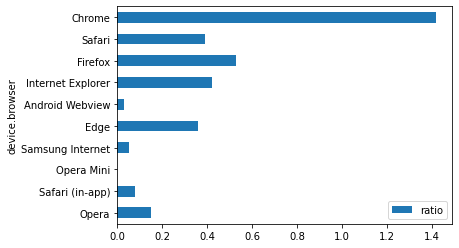

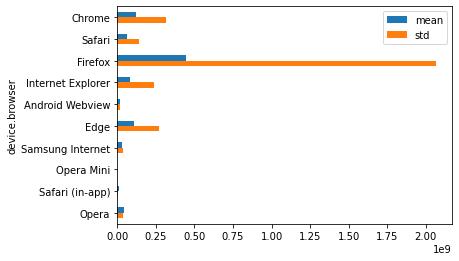

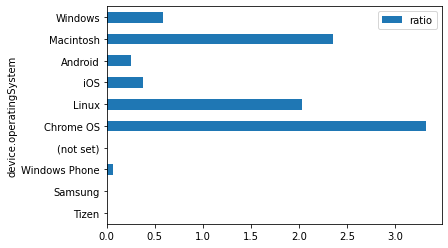

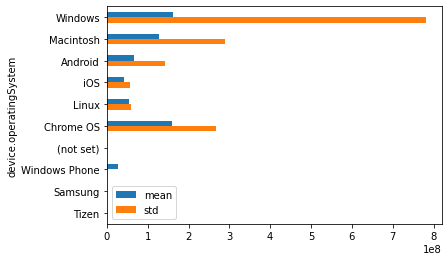

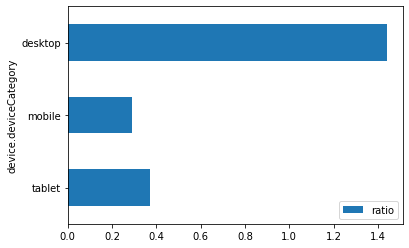

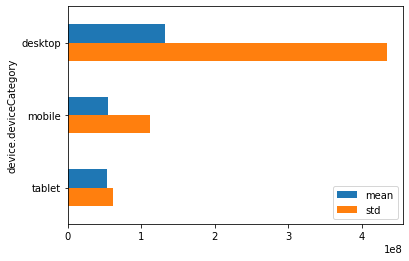

In [130]:
#device.browser
table1 = train.groupby('device.browser')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table1['ratio'] = round((table1['count']/table1['size'])*100,2)
fig1 = table1[['ratio']].plot.barh().invert_yaxis()
fig2 = table1[['mean','std']].plot.barh().invert_yaxis()

#device.operatingSystem
table2 = train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table2['ratio'] = round((table2['count']/table2['size'])*100,2)
fig3 = table2[['ratio']].plot.barh().invert_yaxis()
fig4 = table2[['mean','std']].plot.barh().invert_yaxis()

#device.deviceCategory
table3 = train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table3['ratio'] = round((table3['count']/table3['size'])*100,2)
fig5 = table3[['ratio']].plot.barh().invert_yaxis()
fig6 = table3[['mean','std']].plot.barh().invert_yaxis()


# 2. Time

- Total revenue by month

August has the highest revenue, followed by April

- Mean,std of revenue & count of non-zero revenue user by month

Although the total revenue of either August and April surpass others obviously, the mean revenue of each monther is similar, even the mean revenue of April is slightly higher than August.

The reasons why the overall revenue of August is larger than April is that August has far more customers, even though each of them only purchase little.

- Revenue distribution by weekday and visit hour
(Note: pandas.Series.dt.weekday denote Monday and Sunday by 0 and 6 respectively)
Almost all revenue are created in weekdays, instead of weekends, and most transactions take place from 11pm to 4am.

Considering these 2 parameters: weekday and hour, the golden combination is at 4am on Wednesday.

In [8]:
from datetime import datetime

In [90]:
train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')

In [93]:
#extracting weekday, day, month, year, visit hour respectively
train["weekday"] = train['date'].dt.weekday
train["day"] = train['date'].dt.day 
train["month"] = train['date'].dt.month 
train["year"] = train['date'].dt.year 
train["visitHour"] = (train['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

In [152]:
date = train.groupby(by=['month'])['totals.transactionRevenue'].agg(['count','sum','mean','std'])

In [153]:
date

,count,sum,mean,std
month,,,,
1,1326,1.702149e+11,1.283672e+08,2.464413e+08
2,1278,1.737493e+11,1.359541e+08,5.453965e+08
3,1907,2.202794e+11,1.155110e+08,3.113943e+08
4,1567,2.382231e+11,1.520250e+08,7.149573e+08
5,1115,1.217115e+11,1.091583e+08,2.553799e+08
6,946,1.215695e+11,1.285090e+08,3.741667e+08
7,1031,1.244993e+11,1.207558e+08,4.093907e+08
8,2422,3.107836e+11,1.283169e+08,4.048730e+08
9,1626,2.294364e+11,1.411048e+08,5.945090e+08


In [162]:
ax.plot(date['sum'],label='Total revenue')

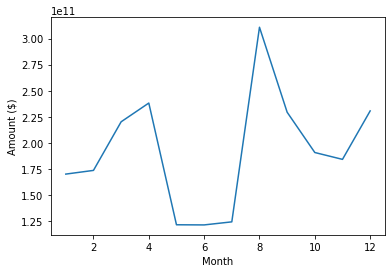

In [175]:
plt.plot(date['sum'])
plt.xlabel('Month')
plt.ylabel('Amount ($)')
plt.title('Total revenue by month')

plt.show()

Text(0, 0.5, 'No of users')

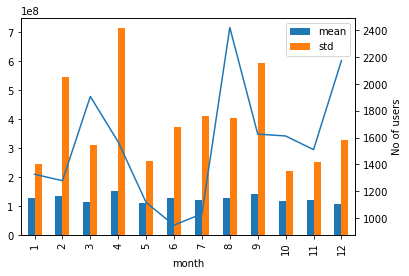

In [170]:
ax = date[['mean','std']].plot(kind="bar", label=['mean','std'])
ax2 = ax.twinx()
ax2.plot(range(0, len(date['count'])), date['count'],label = 'no of users')
ax2.set_ylabel(r"No of users")


In [111]:
weekday_hour = train.pivot_table(index='visitHour',columns='weekday',values='totals.transactionRevenue', aggfunc='sum')

Text(0.5, 1.0, 'Revenue distribution by weekday and visit hour')

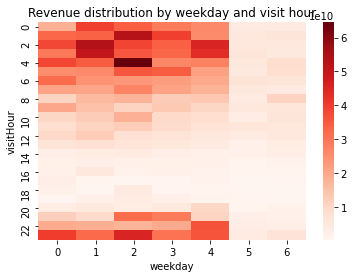

In [119]:
sns.heatmap(weekday_hour, cmap='Reds')
plt.title('Revenue distribution by weekday and visit hour')

# Country

- by continent

For the ratio of customers over all GStore visitors, Americas is the highest.
Although Africa has less customers, some of them spend much on GStore, evidenced by highest mean revenue.

- by country

United States contribute the most revenue, approximately 4 time than that of runner-up, Canada

In [66]:
country = train[['geoNetwork.country','totals.transactionRevenue']].dropna()

In [71]:
country['totals.transactionRevenue']= country['totals.transactionRevenue'].astype(int)

In [73]:
country.groupby(['geoNetwork.country']).sum().sort_values(by=['totals.transactionRevenue'],ascending=False).head(10)

,totals.transactionRevenue
geoNetwork.country,
United States,2197885190000
Canada,42699230000
Venezuela,13901260000
Japan,7361500000
Australia,6585640000
Kenya,5268700000
Mexico,3763080000
Nigeria,3302400000
Taiwan,2934200000


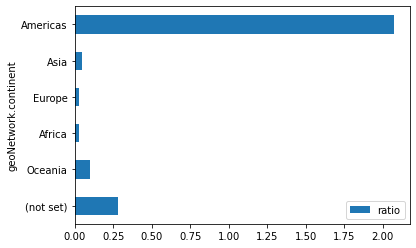

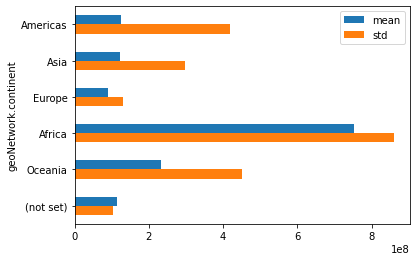

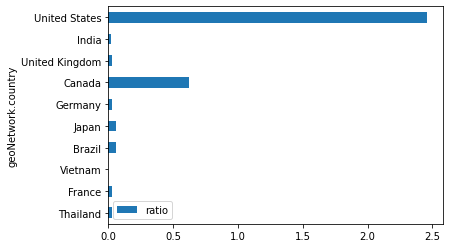

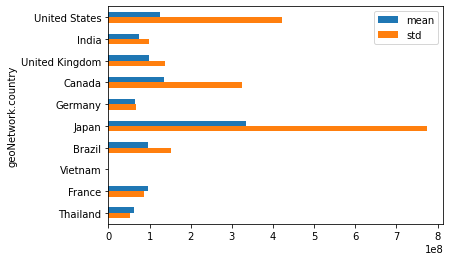

In [176]:
#geoNetwork.continent
table3 = train.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table3['ratio'] = round((table3['count']/table3['size'])*100,2)
fig5 = table3[['ratio']].plot.barh().invert_yaxis()
fig6 = table3[['mean','std']].plot.barh().invert_yaxis()

#geoNetwork.country
table4 = train.groupby('geoNetwork.country')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table4['ratio'] = round((table4['count']/table4['size'])*100,2)
fig7 = table4[['ratio']].plot.barh().invert_yaxis()
fig8 = table4[['mean','std']].plot.barh().invert_yaxis()


# Behaviours

- Hits & pageview

By definition, hit and pageviews refer to the requests to google server and the total number of pages viewed respectively.

The ratio of non-zero revenue users rise gradually with the increase of both hit and pageview.
Also, their mean revenue vary a lot with different no of hit or pageview.
Thus, either no of hit or pageview is a good indicator to distinguish and predict revenue.

- sessionQualityDim
sessionQualityDim is the short form of session quality dimension, it's used to estimate a user’s proximity to conversion. Google Analytics will evaluate each session and score the proximity to conversion in a range from 1 to 100, where 100 means very close to a transaction.

Likewise, the ratio of non-zero revenue users rise gradually with the increase of session quality dimension.
However, unlike hit and pageview, the mean revenue doesn't vary a lot.
Session quality dimension may also be a revenue predictor, but not as good as hit and pageview.


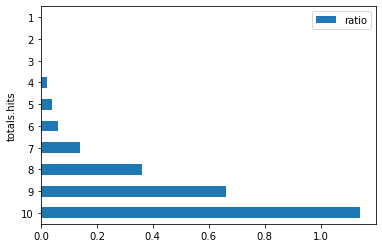

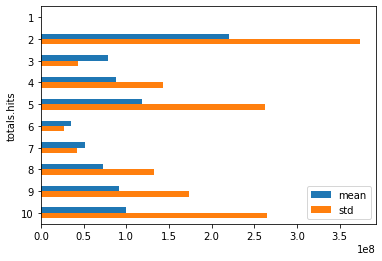

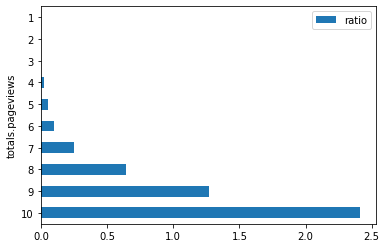

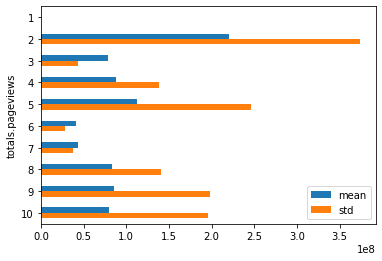

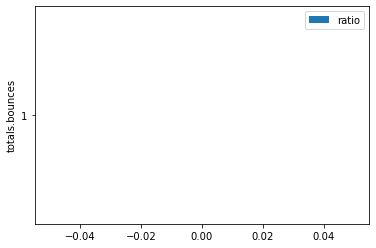

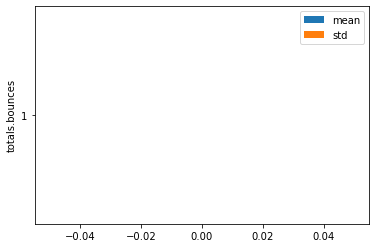

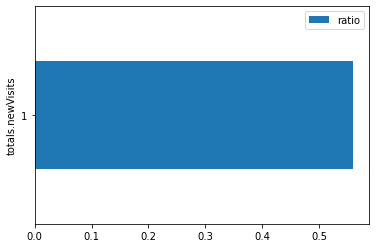

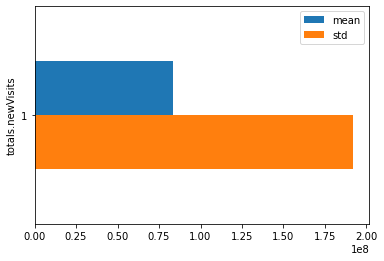

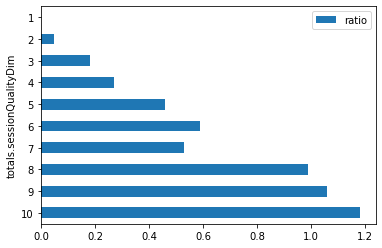

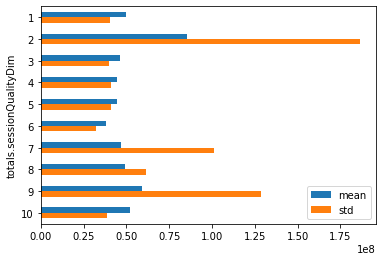

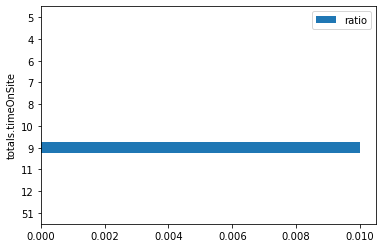

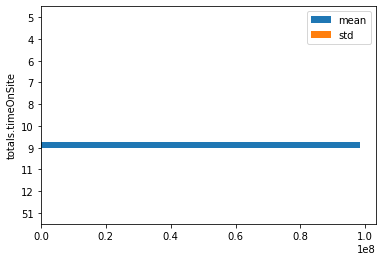

In [127]:
#totals.hits
table5 = train.groupby('totals.hits')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table5['ratio'] = round((table5['count']/table5['size'])*100,2)
fig9 = table5[['ratio']].plot.barh().invert_yaxis()
fig10 = table5[['mean','std']].plot.barh().invert_yaxis()

#totals.pageviews
table6 = train.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table6['ratio'] = round((table6['count']/table6['size'])*100,2)
fig11 = table6[['ratio']].plot.barh().invert_yaxis()
fig12 = table6[['mean','std']].plot.barh().invert_yaxis()

#totals.newVisits
table8 = train.groupby('totals.newVisits')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table8['ratio'] = round((table8['count']/table8['size'])*100,2)
fig15 = table8[['ratio']].plot.barh().invert_yaxis()
fig16 = table8[['mean','std']].plot.barh().invert_yaxis()

#totals.sessionQualityDim
table9 = train.groupby('totals.sessionQualityDim')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table9['ratio'] = round((table9['count']/table9['size'])*100,2)
fig17 = table9[['ratio']].plot.barh().invert_yaxis()
fig18 = table9[['mean','std']].plot.barh().invert_yaxis()

#totals.timeOnSite
table10 = train.groupby('totals.timeOnSite')['totals.transactionRevenue'].agg(['size','count','mean','std']).sort_values(by='size',ascending=False).head(10)
table10['ratio'] = round((table10['count']/table10['size'])*100,2)
fig19 = table10[['ratio']].plot.barh().invert_yaxis()
fig20 = table10[['mean','std']].plot.barh().invert_yaxis()

# Model

In [1]:
import xgboost
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [243]:
train_X = train.drop(columns=['totals.transactionRevenue','totals.totalTransactionRevenue'])
train_Y = train['totals.transactionRevenue'].fillna(0)

In [16]:
for i in [train_X.columns]:
    print(i)

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.bounces', 'totals.newVisits', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactions',
       'totals.totalTransactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.isTrueDirect',
       'trafficSource.adContent', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',

In [245]:
train_X['totals.bounces'] = train_X['totals.bounces'].fillna(0)

In [246]:
train_X['totals.bounces'] = train_X['totals.bounces'].astype(int)

In [247]:
#Handling the missing value
for i in [train_X.columns]:
    train_X[i].fillna(0,inplace=True)

In [250]:
train_X = train_X.drop(columns=['customDimensions',
                                 'hits'])

In [337]:
train_X = train_X.drop(columns=['fullVisitorId','visitStartTime'])

In [255]:
#before change to numeric
train_X.dtypes

channelGrouping                                         object
date                                            datetime64[ns]
fullVisitorId                                           object
visitNumber                                              int64
visitStartTime                                           int64
device.browser                                          object
device.operatingSystem                                  object
device.isMobile                                           bool
device.deviceCategory                                   object
geoNetwork.continent                                    object
geoNetwork.subContinent                                 object
geoNetwork.country                                      object
geoNetwork.region                                       object
geoNetwork.metro                                        object
geoNetwork.city                                         object
geoNetwork.networkDomain                               

In [106]:
numeric_col = ['totals.hits', 
               'totals.pageviews',
               'totals.bounces',
               'totals.newVisits',
               'totals.sessionQualityDim',
               'totals.timeOnSite',
               'totals.transactions']

In [256]:
for i in range(len(numeric_col)):
    train_X[numeric_col[i]] = pd.to_numeric(train_X[numeric_col[i]], errors='ignore', downcast='signed')

In [257]:
#after change to numeric
train_X.dtypes

channelGrouping                                         object
date                                            datetime64[ns]
fullVisitorId                                           object
visitNumber                                              int64
visitStartTime                                           int64
device.browser                                          object
device.operatingSystem                                  object
device.isMobile                                           bool
device.deviceCategory                                   object
geoNetwork.continent                                    object
geoNetwork.subContinent                                 object
geoNetwork.country                                      object
geoNetwork.region                                       object
geoNetwork.metro                                        object
geoNetwork.city                                         object
geoNetwork.networkDomain                               

In [258]:
category_columns = list(train_X.dtypes[train_X.dtypes == 'object'].reset_index()['index'])
numeric_columns = ['visitNumber',
                    'totals.hits', 
                   'totals.pageviews',
                   'totals.bounces',
                   'totals.newVisits',
                   'totals.sessionQualityDim',
                   'totals.timeOnSite',
                   'totals.transactions',
                  'weekday',
                  'day',
                  'month',
                  'year',
                  'visitHour']

for col in category_columns:
    train_X[col] = LabelEncoder().fit_transform(train_X[col].astype(str))

X = train_X[category_columns + numeric_columns]

In [22]:
from sklearn.model_selection import train_test_split

In [343]:
X_train, X_val, y_train, y_val = train_test_split(X, train_Y, test_size=0.3, random_state=46)

In [113]:
import time

In [115]:
import xgboost as xgb

In [345]:
y_train = y_train.astype(int)

In [346]:
#using DMatrix to run xgboost model is faster than using XGBClassifier under sklearn
xgtrain = xgb.DMatrix(X_train, label=y_train)

In [339]:
#hyperparameter tuning
param = {'eta':0.03, 'gamma':1, 'lambda':1, 'max_depth' : 16}
num_round = 300

In [347]:
#param = {'eta':0.03, 'gamma':1, 'lambda':1, 'max_depth' : 16},  num_round=300
start = time.time()
m = xgb.train(param, xgtrain, num_round)
end = time.time()
print("Runtime of the program is {}".format(end - start))

Runtime of the program is 412.1298267841339


In [348]:
xg_val = xgb.DMatrix(X_val)
y_val_pred = m.predict(xg_val)

In [266]:
y_val

1177251    0
1294587    0
1439827    0
1634741    0
284042     0
          ..
1618044    0
869034     0
874941     0
88861      0
1440398    0
Name: totals.transactionRevenue, Length: 512502, dtype: object

In [267]:
y_val_pred

array([5.376339e-05, 5.376339e-05, 5.376339e-05, ..., 5.376339e-05,
       5.376339e-05, 5.376339e-05], dtype=float32)

# Test

In [211]:
test = test.drop(columns=['socialEngagementType',
                            'device.browserVersion',
                            'device.browserSize',
                            'device.operatingSystemVersion',
                            'device.mobileDeviceBranding',
                            'device.mobileDeviceModel',
                            'device.mobileInputSelector',
                            'device.mobileDeviceInfo',
                            'device.mobileDeviceMarketingName',
                            'device.flashVersion',
                            'device.language',
                            'device.screenColors',
                            'device.screenResolution',
                            'geoNetwork.cityId',
                            'geoNetwork.latitude',
                            'geoNetwork.longitude',
                            'geoNetwork.networkLocation',
                            'totals.visits',
                            'trafficSource.adwordsClickInfo.criteriaParameters'])

In [216]:
test['date'] = pd.to_datetime(test['date'], format='%Y%m%d')

In [217]:
test["weekday"] = test['date'].dt.weekday #extracting week day
test["day"] = test['date'].dt.day # extracting day
test["month"] = test['date'].dt.month # extracting day
test["year"] = test['date'].dt.year # extracting day
test['visitHour'] = (test['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

In [293]:
test.dtypes

channelGrouping                                          int64
customDimensions                                         int64
date                                            datetime64[ns]
fullVisitorId                                            int64
hits                                                     int64
visitId                                                  int64
visitNumber                                              int64
device.browser                                           int64
device.operatingSystem                                   int64
device.isMobile                                           bool
device.deviceCategory                                    int64
geoNetwork.continent                                     int64
geoNetwork.subContinent                                  int64
geoNetwork.country                                       int64
geoNetwork.region                                        int64
geoNetwork.metro                                       

In [ ]:
numeric_col = ['totals.hits', 
               'totals.pageviews',
               'totals.bounces',
               'totals.newVisits',
               'totals.sessionQualityDim',
               'totals.timeOnSite',
               'totals.transactions']

In [221]:
for i in range(len(numeric_col)):
    test[numeric_col[i]] = pd.to_numeric(test[numeric_col[i]], errors='ignore', downcast='integer')

In [225]:
test = test.drop(columns=['totals.transactionRevenue',
                            'totals.totalTransactionRevenue'])

In [229]:
test = test.drop(columns=['visitStartTime'])

In [231]:
test_category_columns = list(test.dtypes[test.dtypes == 'object'].reset_index()['index'])
test_numeric_columns = ['visitId',
                   'visitNumber',
                    'totals.hits', 
                   'totals.pageviews',
                   'totals.bounces',
                   'totals.newVisits',
                   'totals.sessionQualityDim',
                   'totals.timeOnSite',
                   'totals.transactions',
                  'weekday',
                  'day',
                  'month',
                  'year',
                  'visitHour']

for col in test_category_columns:
    test[col] = LabelEncoder().fit_transform(test[col].astype(str))

test_X = test[test_category_columns + test_numeric_columns]

In [272]:
test_X = test_X.drop(columns=['customDimensions',
                            'hits',
                            'visitId'])

In [277]:
test_X.dtypes

channelGrouping                                   int64
fullVisitorId                                     int64
device.browser                                    int64
device.operatingSystem                            int64
device.deviceCategory                             int64
geoNetwork.continent                              int64
geoNetwork.subContinent                           int64
geoNetwork.country                                int64
geoNetwork.region                                 int64
geoNetwork.metro                                  int64
geoNetwork.city                                   int64
geoNetwork.networkDomain                          int64
trafficSource.referralPath                        int64
trafficSource.campaign                            int64
trafficSource.source                              int64
trafficSource.medium                              int64
trafficSource.keyword                             int64
trafficSource.adContent                         

In [276]:
X_val.head(1)

,channelGrouping,fullVisitorId,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,...,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,weekday,day,month,year,visitHour
1177251,7,681543,35,20,0,2,15,28,482,122,...,1,1.0,NaN,NaN,NaN,0,23,1,2017,11


In [351]:
test_X = test_X.drop(columns=['fullVisitorId'])

In [352]:
xg_test = xgb.DMatrix(test_X[X_train.columns])
y_test_pred = m.predict(xg_test)

In [374]:
submission = test['fullVisitorId']

In [364]:
y_test_pred

array([5.3703785e-05, 5.3703785e-05, 5.3703785e-05, ..., 5.3703785e-05,
       5.3703785e-05, 5.3703785e-05], dtype=float32)

In [376]:
submission = pd.concat([submission, pd.DataFrame(y_test_pred)], axis=1)

In [378]:
submission = submission.rename(columns={0:'PredictedLogRevenue'})

In [379]:
submission.loc[submission['PredictedLogRevenue']<0] = 0

In [381]:
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()

In [369]:
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])

In [360]:
submission.to_csv('GA_revenue_prediction.csv', index=False)

In [382]:
submission

,fullVisitorId,PredictedLogRevenue
0,0,0.000000
1,0000018966949534117,0.000054
2,0000039738481224681,0.000054
3,0000073585230191399,0.000054
4,0000087588448856385,0.000054
...,...,...
296523,9999862054614696520,0.000054
296524,9999898168621645223,0.000054
296525,999990167740728398,0.000054
296526,9999915620249883537,0.000054
